# Exploratory Analysis
<span style="font-size:13pt;">
As a person who plays games, I'm not too familar with the Metacritic score. I haven't used this to guage if a game is "great" or not. I hear about games through word of mouth and the constance advertisements that get thrown at me. Metacritic game scores have been around for a while and it may give some insights on how users percive the games the overall quality of the games. This is just a informal analysis of the metacritic scores attributed to games gathered over time. I'd like to see if I can learn anything about metacritic scores or about game industry.
Below is a description of the metacritic score:
<br>Metascore is a weighted average in that we assign more importance, or weight, to some critics and publications than others, based on their quality and overall stature
Metascores range from 0-100, with higher scores indicating better overall reviews. We highlight Metascores in three colors so that you can instantly compare: green scores for favorable reviews, yellow scores for mixed reviews, and red scores for unfavorable reviews.(https://www.metacritic.com/about-metascores)
Our goal for this analysis is to see if there is any relationship we can between the metascore and other metrics that are provided
   

# Reading Data

In [160]:
import math
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sb

In [161]:
data = pd.read_csv('../input/metacritic-all-time-games-stats/metacritic_games.csv', parse_dates=['release_date'])
print(data.head(5))

                          name platform         developer           publisher  \
0            Command & Conquer       PC  Westwood Studios  Virgin Interactive   
1                Full Throttle       PC         LucasArts           LucasArts   
2       Battle Arena Toshinden       PS           Tamsoft                SCEA   
3  Sid Meier's Civilization II       PC          MPS Labs          MicroProse   
4                        Quake       PC       id Software         id Software   

    genre(s)   players rating attribute release_date  \
0     Sci-Fi      1-4       T       NaN   1995-08-31   
1  Adventure       NaN    NaN       NaN   1995-04-30   
2     Action      1-2       T       NaN   1995-09-09   
3   Strategy  1 Player    K-A       NaN   1996-02-29   
4     Action     1-16       M       NaN   1996-06-22   

                                       link  critic_positive  critic_neutral  \
0                  /game/pc/command-conquer                5               0   
1               

<span style="font-size:13pt;">  Reading in the data went well. However after checkign the output of the data that we are working with I notice the date format is not to my liking. So I chose to update it to a comfortable format. Of course we want to ensure the data we are working with is complete, so we check the number of NULL values, earliest date and latest date we are working with. 


In [162]:
data['release_date'] = pd.to_datetime(data['release_date'], format='%m/%d/%Y')
data['release_year'] = data['release_date'].dt.year
print(data.isnull().sum(), '\n\n')
print('Earliest Date:',data['release_date'].min(),'\nLatest Date: ', data['release_date'].max())

name                   0
platform               0
developer             37
publisher              6
genre(s)               0
players             7229
rating              2291
attribute          20098
release_date           0
link                   0
critic_positive        0
critic_neutral         0
critic_negative        0
metascore              0
user_positive          0
user_neutral           0
user_negative          0
user_score             0
release_year           0
dtype: int64 


Earliest Date: 1995-04-30 00:00:00 
Latest Date:  2018-12-27 00:00:00


<span style="font-size:13pt;">
It looks like we have quite a lot of NULL values under a few of the columns. However, for this analysis we wont be using players, rating, and attribute. We can take a quick summary on the numerical values we have in the dataset

In [163]:
data.describe()

,critic_positive,critic_neutral,critic_negative,metascore,user_positive,user_neutral,user_negative,release_year
count,20422.000000,20422.000000,20422.000000,20422.000000,20422.000000,20422.000000,20422.000000,20422.00000
mean,10.807463,7.237391,1.529331,68.826902,16.880472,4.607580,6.389874,2010.18343
std,14.997891,7.239200,3.182006,13.248435,71.851614,16.328698,51.877636,5.45160
min,0.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,1995.00000
25%,1.000000,2.000000,0.000000,61.000000,1.000000,0.000000,0.000000,2006.00000
50%,5.000000,5.000000,0.000000,71.000000,3.000000,1.000000,1.000000,2010.00000
75%,14.000000,10.000000,2.000000,78.000000,10.000000,3.000000,3.000000,2015.00000
max,118.000000,60.000000,51.000000,99.000000,3029.000000,507.000000,3001.000000,2018.00000


<span style="font-size:13pt;">
The quick descriptive stats above indicates that the mean metascore of all the games in the dataset is ~68.8 with a min value of 8 and a highest score of 99. The median is 71 and upper quantile and lower quantiles are 78 and 61 respectively.
Its also interesting to note that there are games with no reviews done by critics or users. 

# Visualization 
<span style="font-size:13pt;">
While looking at data tables can sometimes be helpful, it doesn't give us the full picture of what is going on. Lets look at some publisher data

In [164]:
avg_publisher = data[['publisher','metascore']].groupby(['publisher']).mean('metascore').sort_values(by='metascore', ascending=False).reset_index(drop=False)
print(avg_publisher.head(10))

               publisher  metascore
0                 2D Boy  94.000000
1            id Software  94.000000
2       Number None Inc.  93.000000
3                tobyfox  92.333333
4  Looking Glass Studios  92.000000
5              Psygnosis  91.000000
6               Trapdoor  91.000000
7              increpare  90.000000
8            989 Studios  90.000000
9       Westwood Studios  90.000000


<span style="font-size:13pt;"> Based on the above output, it appears that top 10 publishers have meta scores between 90 and 94. However, to me this looks unsual since I never heard of these publishers. Lets look into how many games were from these publishers

In [165]:
def counts_name_cols(df,colname):
    """
    Function will take in a dataframe and a column name and will get counts based on column name. 
    Then will a add the total counts to the name of the dataset in the following format ""<name> (counts)""
    """
    df['counts'] = ''
    temp_counts = data[[colname,'name']].groupby([colname]).count().reset_index(drop=False)
    for cname in (df[colname].unique()):
        df.loc[df[colname]==cname,'counts'] = temp_counts.loc[temp_counts[colname]==cname,'name'].values
    df['pname'] = df[colname] + "("+ df['counts'].astype(str) + ")"    
    return df   

avg_publisher = counts_name_cols(avg_publisher,'publisher')
print(avg_publisher[['publisher','metascore','counts']].head(10))

               publisher  metascore counts
0                 2D Boy  94.000000      1
1            id Software  94.000000      1
2       Number None Inc.  93.000000      2
3                tobyfox  92.333333      3
4  Looking Glass Studios  92.000000      1
5              Psygnosis  91.000000      1
6               Trapdoor  91.000000      1
7              increpare  90.000000      1
8            989 Studios  90.000000      1
9       Westwood Studios  90.000000      1


<span style="font-size:13pt;"> Looking at the output, it makes sense why these publishers have such a high average metascore. It's because the very few games they had published already all had very high scores. For our purposes, this is not helpful. I want to look at publishers that have published many games. Lets filter down the list to publishers who have created more than 300 titles.

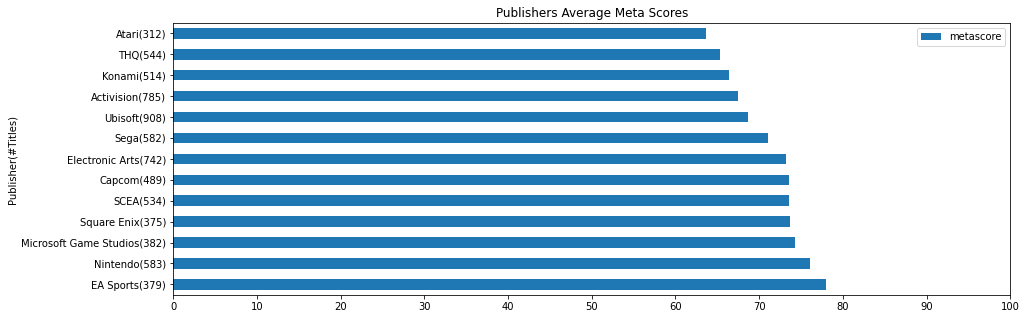

In [166]:
avg_publisher = counts_name_cols(avg_publisher,'publisher')
avg_publisher_sub = avg_publisher.loc[avg_publisher['counts']>300].reset_index(drop=True)
ax = avg_publisher_sub.plot.barh(x='pname', y='metascore',xticks=np.arange(0,110,10), xlabel='Publisher(#Titles)'
                                     ,title='Publishers Average Meta Scores', ylabel='Metascore', figsize=(15,5))

<span style="font-size:13pt;"> Great! It appears that the top publishers are some of the ones that I've known. It's interesting to see that EA sports would have the highest metascore. Lets look into if there is any difference across platforms

In [167]:
avg_platform = data[['platform','metascore']].groupby(['platform']).mean('metascore').sort_values(by='metascore', ascending=False).reset_index(drop=False)
avg_platform = counts_name_cols(avg_platform,'platform')
print(avg_platform[['platform','metascore','counts']].head(15))

   platform  metascore counts
0       N64  75.134831     89
1        DC  71.531469    143
2      VITA  70.691176    408
3      XONE  70.618251   1315
4    Switch  70.305521    815
5        PC  70.154736   5448
6       PS4  70.001647   1822
7       PS3  69.770636   1478
8        PS  69.269531    256
9      XBOX  69.097852    838
10       GC  69.095703    512
11      PS2  68.028086   1531
12     X360  67.914348   1833
13      PSP  67.741351    607
14     WIIU  67.678125    320


<span style="font-size:13pt;">From the above output, it looks like the average for the platforms are between the ranges of 62-75 which according to Metacritic.com is between "Mixed or Average Review" to "Generally Favorable". However, some of these are unfamilar, which is why we also added the number of titles made per platform.
Based on the new output, the N64 being the top average metascore seems to be "skweded" in the larger picture since there are platforms that have made thousands of games. Lets filter our data to only platforms that have over more than 800 games and see how their metascores compare with each other

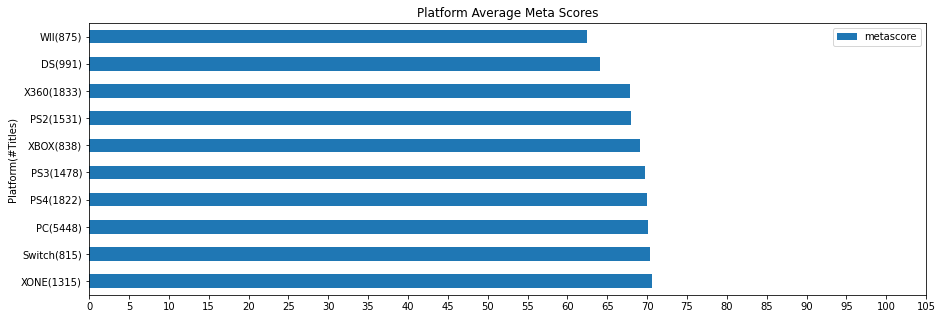

In [168]:
avg_platform_sub = avg_platform.loc[avg_platform['counts']>800].reset_index(drop=True)
ax = avg_platform_sub.plot.barh(x='pname', y='metascore',xticks=np.arange(0,110,5), xlabel='Platform(#Titles)'
                                     ,title='Platform Average Meta Scores', ylabel='Metascore', figsize=(15,5))

<span style="font-size:13pt;">The average metascore ranges appears to be between 63 and 71 which for our case is "Average". Its good to see that the PC platform has is in the top 3 since I only really have played PC games. Not only it is in the top 3, it also has a much larger library of games with over 5000 titles! Lets look at how PC games from the year 2000 and onward does. 

                  name
genre(s)              
Action            1424
Action Adventure   517
Adventure          577
Role-Playing       594
Strategy           992


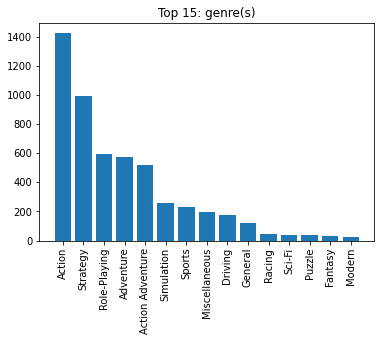

In [169]:
def top_15_bar(data,plot_variable): 
    """
    Function will take in a dataframe and a variable name to create a barplot
    """
    genre_subdata = subdata.groupby(plot_variable).count().reset_index(drop=False)
    genre_subdata = genre_subdata.sort_values(by='name', ascending=False).head(15)
    genre_subdata_counts = genre_subdata.iloc[:,0:2] 
    genre_subdata_counts.columns = [plot_variable, 'Counts'] 
    plt.bar(genre_subdata_counts[plot_variable], genre_subdata_counts['Counts'])
    plt.xticks(rotation=90); plt.title('Top 15: '+str(plot_variable))
    return 

subdata = data.loc[data['platform'] == 'PC'].reset_index(drop=True) 
subdata = subdata.loc[subdata['release_year'] >= 2000].reset_index(drop=True) 
top_15_bar(subdata,'genre(s)')

top5list_genre = ['Action','Strategy','Role-Playing','Adventure','Action Adventure']
top5genres_data = subdata[subdata['genre(s)'].isin(top5list_genre)].reset_index(drop=True)
print(top5genres_data[['genre(s)','name']].groupby('genre(s)').count())

<span style="font-size:13pt;">
From the above chart, we see that the top PC genres. It was to be expected if we were given the list. From the many games that I have played they all fit those category. There is a significant drop off after Action adventure games. Lets drill down into only the top 5 genres. It is important to note that the action genre also has more than double the amount of games than three of the genres. We can look at the distribution of the metascores for each of the genres below

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


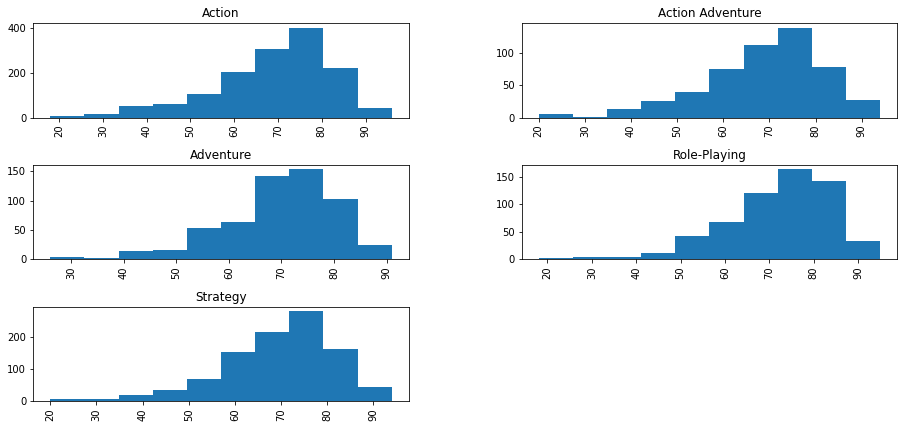

In [170]:
genre_hist = top5genres_data.hist(column ='metascore',by='genre(s)', figsize=(15,7), bins=10)

<span style="font-size:13pt;">
We can see that data given is distributed nicely. However, the total counts for each genre varies from 100s to 400s which indicates that the Action genre would have the most games 

Genre Median:
                    metascore
genre(s)                   
Action                   71
Action Adventure         71
Adventure                71
Role-Playing             74
Strategy                 71 

Genre Mean:
                    metascore
genre(s)                   
Action            68.845506
Action Adventure  68.930368
Adventure         69.299827
Role-Playing      71.799663
Strategy          69.530242


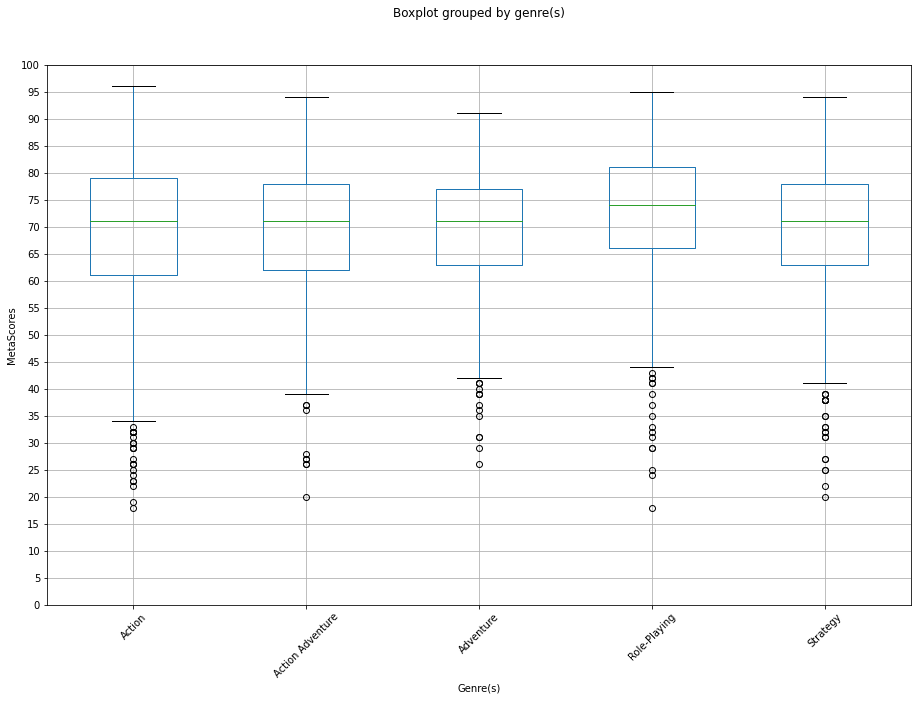

In [171]:
top5genres_data.boxplot(column='metascore', by='genre(s)', figsize = (15,10), grid=True, rot=45)
plt.yticks(ticks=np.arange(0,105,5))
plt.ylabel('MetaScores') ;plt.xlabel('Genre(s)');plt.title('')
print("Genre Median:\n ",top5genres_data[['genre(s)','metascore']].groupby('genre(s)').median(),"\n");
print("Genre Mean:\n ",top5genres_data[['genre(s)','metascore']].groupby('genre(s)').mean())

<span style="font-size:13pt;">
Based on the above stats and boxplot, we can see that the median metascore of all five genres which are all close to each other. Based on metacritic they are all mixed review. While this is infomation is somewhat useful.  We can see there isn't a genre that is superiorilly more liked among the top five, with only role-playing taking the lead by 3 points. Role-playing also has a higher Q1 and Q3 range among the other four genres. Role-playing game seems to be more favrable compared to the the other four. This is also supported by the average of the meta scores based on genres. 

Text(0, 0.5, '# of Release')

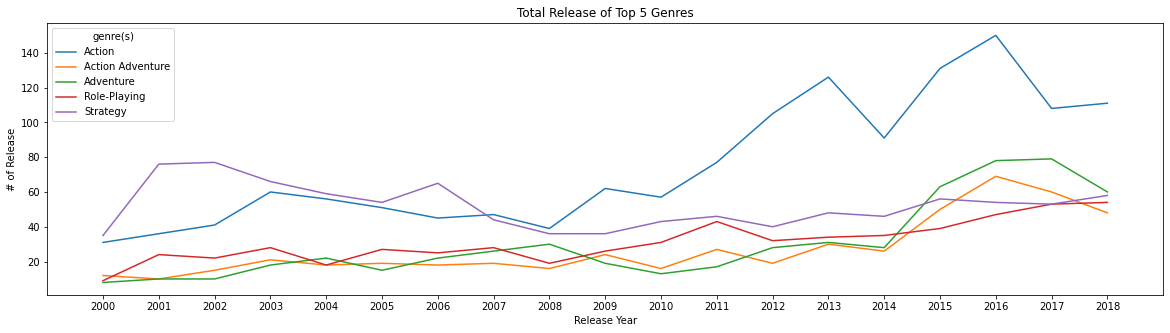

In [172]:
fig, axs = plt.subplots(figsize=(20,5))    
temp = (top5genres_data.groupby(['release_year','genre(s)']).count()).reset_index(drop=False)    
temp = temp[['release_year','genre(s)','name']]

t = sb.lineplot(data=temp, x='release_year',y='name', hue='genre(s)') ; t.set(xlim=(1999,2019),xticks=temp['release_year'].unique())
plt.title('Total Release of Top 5 Genres'); plt.xlabel('Release Year'); plt.ylabel('# of Release')


In [173]:
<span style="font-size:13pt;">As we can see from the above published genres was the highest producing genre over the course of 18 years which is to be expected from our previous histogram. Its important to note that the action genre had a signifcant jump of PC games release from 2008 to 2013. Based on a quick search what games were release during that time popular titles include [Mass Effect, Fallout, Bioshock, Battlefield, Call of Duty, Red Dead Redemption, Splinter Cell, Assassian's Creed, etc.] Based on this infomation, should we expect well known publishing companies to be on the top of the list?

Init signature: list(iterable=(), /)
Docstring:     
Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified.
Type:           type
Subclasses:     _HashedSeq, StackSummary, _Accumulator, DeferredConfigList, SList, _ImmutableLineList, FormattedText, NodeList, _ExplodedList, Stack, ...


In [ ]:
<span style="font-size:13pt;">As we can see from the above published genres was the highest producing genre over the course of 18 years which is to be expected from our previous histogram. Its important to note that the action genre had a signifcant jump of PC games release from 2008 to 2013. Based on a quick search what games were release during that time popular titles include [Mass Effect, Fallout, Bioshock, Battlefield, Call of Duty, Red Dead Redemption, Splinter Cell, Assassian's Creed, etc.] Based on this infomation, should we expect well known publishing companies to be on the top of the list

<span style="font-size:13pt;">As we can see from the above published genres was the highest producing genre over the course of 18 years which is to be expected from our previous histogram. Its important to note that the action genre had a signifcant jump of PC games release from 2008 to 2013. Based on a quick search what games were release during that time popular titles include [Mass Effect, Fallout, Bioshock, Battlefield, Call of Duty, Red Dead Redemption, Splinter Cell, Assassian's Creed, etc.] Based on this infomation, should we expect well known publishing companies to be on the top of the list

<span style="font-size:13pt;">As we can see from the above published genres was the highest producing genre over the course of 18 years which is to be expected from our previous histogram. Its important to note that the action genre had a signifcant jump of PC games release from 2008 to 2013. Based on a quick search what games were release during that time popular titles include [Mass Effect, Fallout, Bioshock, Battlefield, Call of Duty, Red Dead Redemption, Splinter Cell, Assassian's Creed, etc.] Based on this infomation, should we expect well known publishing companies to be on the top of the list

             publisher  # Games
0              Ubisoft      204
1      Electronic Arts      184
2       Telltale Games      115
3  Paradox Interactive      111
4           Activision      111
5                Atari      110


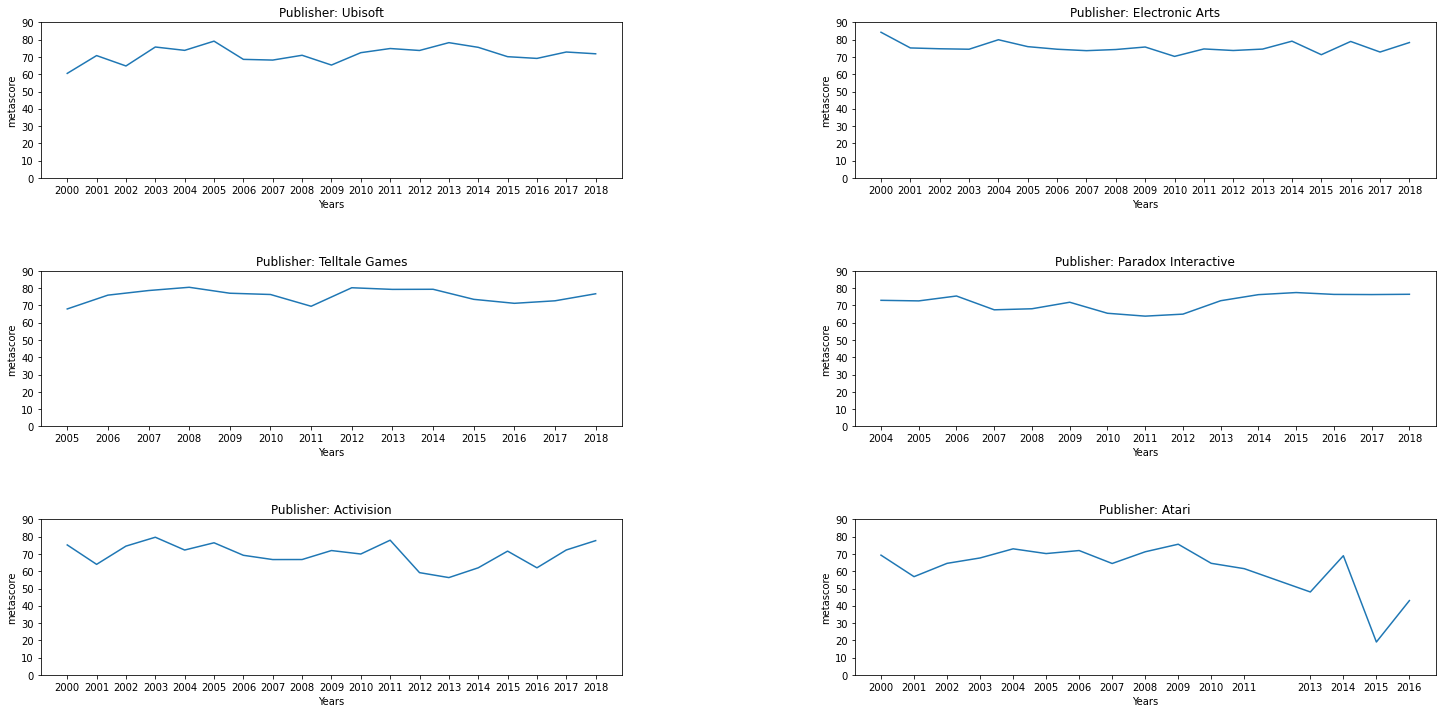

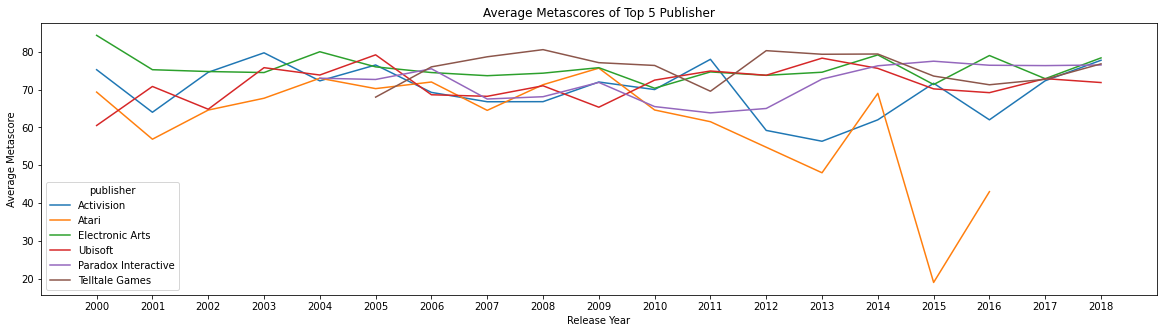

In [174]:
def plot_over_release_year(data,colname,title):
    """
    Function will take in a dataframe, column name and a title to be used. 
    Will plot over time values for column name
    """
    c = i%2 
    r= int(i/2)
    axes[r,c].plot(data['release_year'].astype(int), data[colname])
    axes[r,c].set_title(str(title)) 
    axes[r,c].set_xlabel('Years'); axes[r,c].set_ylabel(colname)
    axes[r,c].set_xticks(data['release_year'])
    return

pubdata = (subdata.groupby('publisher').count())
pubdata = pubdata.sort_values(by='name', ascending=False).head(15).reset_index(drop=False)

publisting = ['Ubisoft','Electronic Arts','Telltale Games','Paradox Interactive','Activision','Atari']
sub_pubdata = pubdata.loc[pubdata['publisher'].isin(publisting),:'name'].reset_index(drop=True)
sub_pubdata.columns = ['publisher','# Games']
print(sub_pubdata)

pub_meta = subdata.loc[subdata['publisher'].isin(publisting)].reset_index(drop=True)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25,12))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i, p in enumerate(publisting):
    c = i%2 
    r= int(i/2)
    counts_by_pub = pub_meta.loc[pub_meta['publisher']==p].groupby('release_year').mean('metascore').reset_index(drop=False)
    counts_by_pub = counts_by_pub[['release_year','metascore']]
    counts_by_pub.columns = ['release_year', 'metascore'] #rename columns 
    plot_over_release_year(counts_by_pub,'metascore','Publisher: '+p)
    axes[r,c].set_yticks(np.arange(0,100,10))

fig, axs = plt.subplots(figsize=(20,5))    
temp2 = (pub_meta.groupby(['release_year','publisher']).mean('metascore')).reset_index(drop=False)    
temp2 = temp2[['release_year','publisher','metascore']]


total_line = sb.lineplot(data=temp2, x='release_year',y='metascore', hue='publisher') ;total_line.set(xlim=(1999,2019),xticks=temp['release_year'].unique())
plt.title('Average Metascores of Top 5 Publisher'); plt.xlabel('Release Year'); plt.ylabel('Average Metascore');

<span style="font-size:13pt;">Based on the number of total games from each of the publishers listed above, they all seem to have similar average meta scores.Activision, Electronic Arts, and Ubisoft were expected. Telltale Games, Paradox Interactive and Atari were not expected. Overall there isn't much difference overall through time periods except for Activision and Atari in 2012 - 2015. 
A quick google search of Atari's history indicates that in 2013 the company filed for bankruptcy  and in 2014 announced a new coporate strategy to shift focus on new audiences.
As for Activision,the google search indicated that they shuttered many of their developers due to losses in revenue from the prior year. From there, Activision put more efforts into their Call of duty francise 

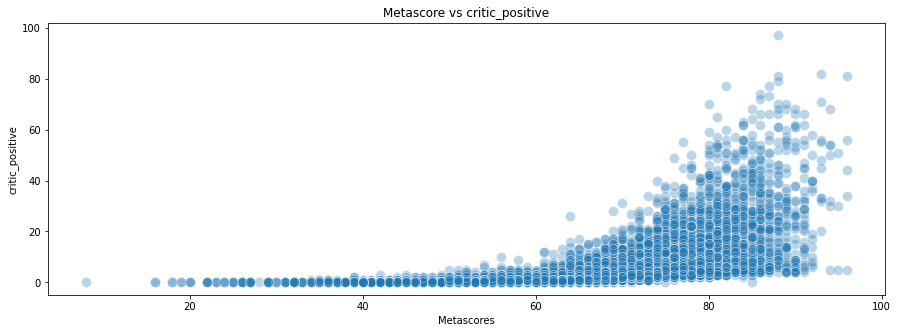

In [175]:
fig, axes = plt.subplots(figsize=(15,5))
axes.scatter(x='metascore',y='critic_positive', data=subdata, s=100, alpha=0.3, edgecolor = 'white')
axes.set_title('Metascore vs critic_positive'); axes.set_xlabel('Metascores'); axes.set_ylabel('critic_positive');

<span style="font-size:13pt;">As you can see from the above, there is a strong exponential relationship between the metacritic scores and the number of positive critics as the weight of each critic is weighted differently as described in the beginning. This isn't surprising since Metacritic indicated that the score is based on their assignment of importance and weight to of critics's quality and overall stature. 

# Conclusion & Comments
<span style="font-size:13pt;">
Based on the given data already as well as the infomation on the metacritic scores from metacritic's website we can also agree that the metacritic score is strongly based on critic's review. If we were provided data on the critics that review the games, we can potentially see which critics have a higher weight on the metascores that are assigned. It would have been nice to see the missing years of 2019 and onwards as there have been many new games and consoles that came out. It would have been interesting to see if any of the newer consoles would have made it on the top list or if any of the newer games would have bumped genres higher. A quick search of top PC  games in 2019 and 2020 included titles like DOOM, Half-Life, Valorant, Apex Legends, Call Of Duty Black Ops  and Call of Duty Modern Warfare were so popular at the time everyone I knew was playing those games.

<span style="font-size:13pt;">
During the analysis I notice in the analysis is that the games usually have multiple genres. The dataset only included one genre per game. It'll be interesting to see how the genres were coded if the first genre tagged on a game was chosen. For example the game "Star Wars Jedi Knight: Dark Forces II" is tagged as an action game while "Star Wars: Knights of the Old Republic" is tagged as a role-playing game. Dark Forces II does also have action-adventure qualities and Knights of the Old Republic does have some action aspects. So having the top genres of "action" , "action-adventure" and "adventure" may very well change if this is clarified. Genre's like "Sci-fi" would also get roped into action or adventure.
 <br>Another thing I notice in the analysis is that PC had an overwhelming number of games in the analysis. If we think about it, PCs themselves don't change as a console. PC's hardware can easily just get upgraded by swapping parts in and out. 
While acutal consoles will have to be purchased whole. For example in the above analysis, if we consider the top metascore average by platform, we can see that there are platforms such as PS2, PS3, PS4, Xbox, Xbox360. If we were to consolidate them into just Playstation and Xbox entirely, we can get 4,831 and 2,671 games respectively. By doing this the average scores can be shifted and we may find a platform with overwhelming preference.